In [ ]:
import sys

# Setup

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/MyDrive/cm146/pset1']
### ========== TODO : END ========== ###


In [ ]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Models

In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set

        counts = Counter(y)
        total = len(y)
        self.probabilities_ = {cls: count/total for cls, count in counts.items()}


        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)

        classes = list(self.probabilities_.keys())
        probs = [self.probabilities_[cls] for cls in classes]
        y = np.random.choice(classes, size=len(X), p=probs)


        ### ========== TODO : END ========== ###

        return y


# Auxiliary functions

In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels

In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials

    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    train_errors = []
    test_errors = []
    f1_scores = []
    for train_idx, test_idx in sss.split(X, y):
         X_train, X_test = X[train_idx], X[test_idx]
         y_train, y_test = y[train_idx], y[test_idx]
         clf.fit(X_train, y_train)
         y_train_pred = clf.predict(X_train)
         y_test_pred = clf.predict(X_test)
         train_errors.append(1 - metrics.accuracy_score(y_train, y_train_pred))
         test_errors.append(1 - metrics.accuracy_score(y_test, y_test_pred))
         f1_scores.append(metrics.f1_score(y_test, y_test_pred, average='micro'))
    train_error = np.mean(train_errors)
    test_error = np.mean(test_errors)
    f1_score = np.mean(f1_scores)



    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score

In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()

# Evaluation

Plotting...


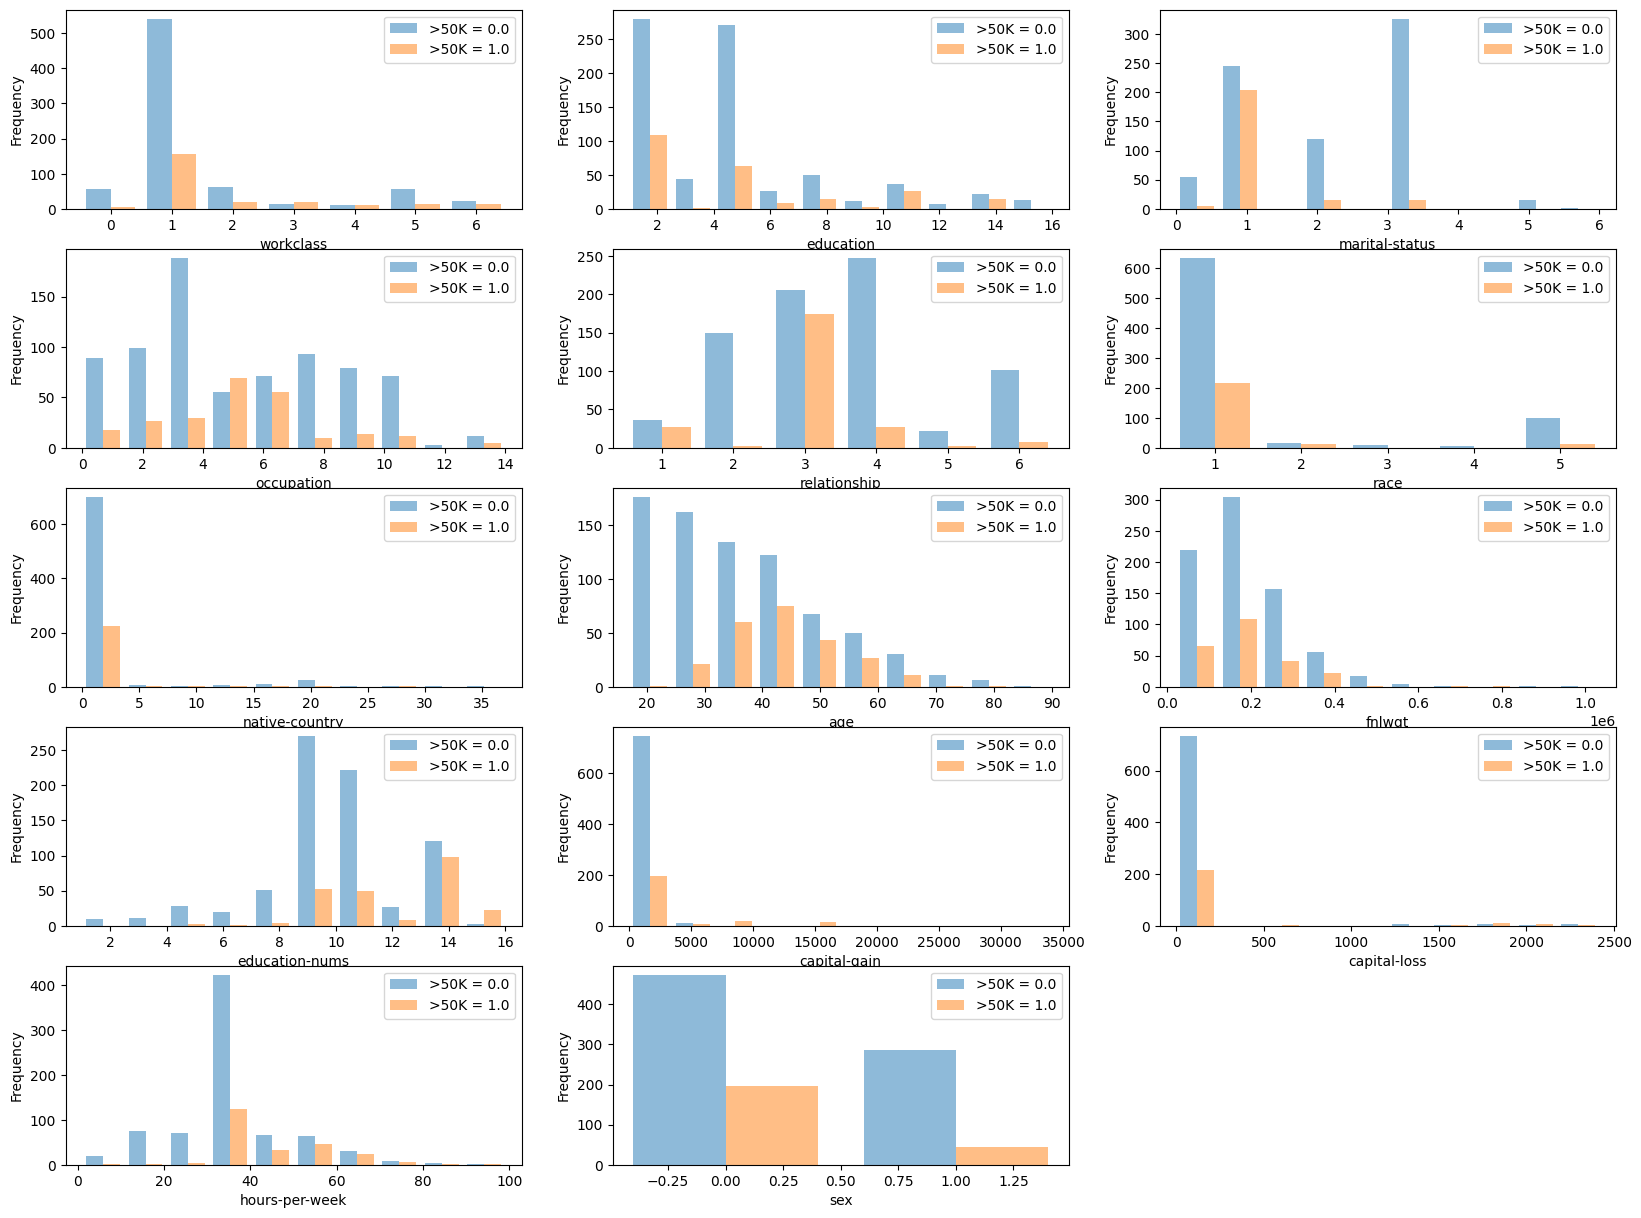

Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.385
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- k = 3, training error: 0.114
	-- k = 5, training error: 0.129
	-- k = 7, training error: 0.152
Investigating various classifiers...
MajorityVote: Avg Training Error: 0.240, Avg Test Error: 0.240, Avg F1: 0.760
Random: Avg Training Error: 0.372, Avg Test Error: 0.373, Avg F1: 0.627
DecisionTree: Avg Training Error: 0.000, Avg Test Error: 0.206, Avg F1: 0.794
KNN (k=5): Avg Training Error: 0.133, Avg Test Error: 0.209, Avg F1: 0.791
Finding the best k...
	-- Best k: 27 with validation error: 0.173


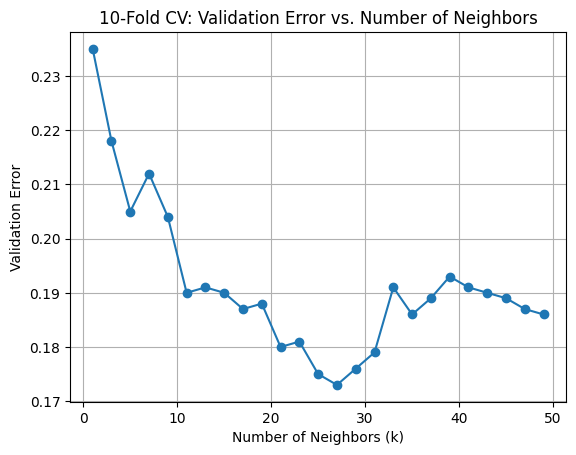

Investigating depths...
	-- Best depth: 5 with test error: 0.179


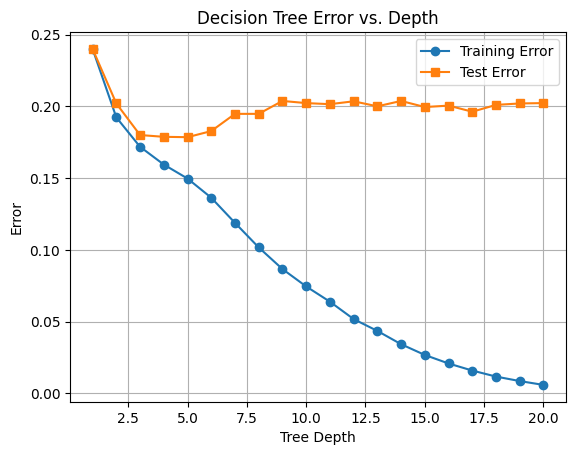

	-- Learning curves evaluation complete.


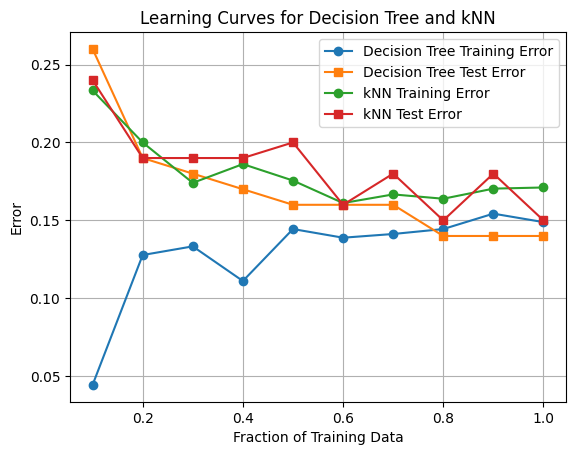

Done


In [ ]:

######################################################################
# main
######################################################################

def main():
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/cm146/pset1/adult_subsample.csv"
    ### ========== TODO : END ========== ###


    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features




    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    plt.show()



    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)

    # X = ?

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier

    print('Classifying using Random...')
    clf = RandomClassifier ()
    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred)
    print('\t-- training error: %.3f' % train_error)

    # print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier

    print('Classifying using Decision Tree...')
    clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred)
    print('\t-- training error: %.3f' % train_error)

    # print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors

    print('Classifying using k-Nearest Neighbors...')
    for k in [3, 5, 7]:
         clf = KNeighborsClassifier(n_neighbors=k)
         clf.fit(X, y)
         y_pred = clf.predict(X)
         train_error = 1 - metrics.accuracy_score(y, y_pred)
         print('\t-- k = %d, training error: %.3f' % (k, train_error))


    # print the error for each k


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')
    classifiers = [
         ("MajorityVote", MajorityVoteClassifier()),
         ("Random", RandomClassifier()),
         ("DecisionTree", DecisionTreeClassifier(criterion='entropy', random_state=0)),
         ("KNN (k=5)", KNeighborsClassifier(n_neighbors=5))
    ]
    for name, clf in classifiers:
         tr_err, te_err, f1 = error(clf, X, y, ntrials=100, test_size=0.2)
         print(f'{name}: Avg Training Error: {tr_err:.3f}, Avg Test Error: {te_err:.3f}, Avg F1: {f1:.3f}')

    # clf =

    # summary = error(clf, X, y, ntrials=20)
    # print(summary)
    ### ========== TODO : END ========== ###






    ### ========== TODO : START ==========
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    k_values = list(range(1, 51, 2))  # odd values from 1 to 50
    validation_errors = []
    for k in k_values:
          clf = KNeighborsClassifier(n_neighbors=k)
          scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
          validation_errors.append(1 - scores.mean())
    best_k = k_values[np.argmin(validation_errors)]
    print('\t-- Best k: %d with validation error: %.3f' % (best_k, min(validation_errors)))

    # Plot the validation error vs. k
    plt.figure()
    plt.plot(k_values, validation_errors, marker='o', linestyle='-')
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Validation Error")
    plt.title("10-Fold CV: Validation Error vs. Number of Neighbors")
    plt.grid(True)
    plt.show()
    ### ========== TODO : END ==========





    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    depths = range(1, 21)
    train_errors = []
    test_errors = []
    sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    for depth in depths:
         temp_train = []
         temp_test = []
         for train_idx, test_idx in sss.split(X, y):
             X_train, X_test = X[train_idx], X[test_idx]
             y_train, y_test = y[train_idx], y[test_idx]
             clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
             clf.fit(X_train, y_train)
             temp_train.append(1 - metrics.accuracy_score(y_train, clf.predict(X_train)))
             temp_test.append(1 - metrics.accuracy_score(y_test, clf.predict(X_test)))
         train_errors.append(np.mean(temp_train))
         test_errors.append(np.mean(temp_test))
    best_depth = depths[np.argmin(test_errors)]
    print('\t-- Best depth: %d with test error: %.3f' % (best_depth, min(test_errors)))

    # Plot the average training and test error versus the depth limit
    plt.figure()
    plt.plot(depths, train_errors, label='Training Error', marker='o')
    plt.plot(depths, test_errors, label='Test Error', marker='s')
    plt.xlabel('Tree Depth')
    plt.ylabel('Error')
    plt.title('Decision Tree Error vs. Depth')
    plt.legend()
    plt.grid(True)
    plt.show()



    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)
    from sklearn.model_selection import train_test_split
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
    training_sizes = np.linspace(0.1, 1.0, 10)
    dt_train_errors = []
    dt_test_errors = []
    knn_train_errors = []
    knn_test_errors = []
    for frac in training_sizes:
         idx = np.random.choice(len(X_train_full), size=int(frac*len(X_train_full)), replace=False)
         X_train_frac = X_train_full[idx]
         y_train_frac = y_train_full[idx]
         # Decision Tree using best_depth from part g
         clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, random_state=0)
         clf_dt.fit(X_train_frac, y_train_frac)
         dt_train_errors.append(1 - metrics.accuracy_score(y_train_frac, clf_dt.predict(X_train_frac)))
         dt_test_errors.append(1 - metrics.accuracy_score(y_test, clf_dt.predict(X_test)))
         # kNN using best_k from part f
         clf_knn = KNeighborsClassifier(n_neighbors=best_k)
         clf_knn.fit(X_train_frac, y_train_frac)
         knn_train_errors.append(1 - metrics.accuracy_score(y_train_frac, clf_knn.predict(X_train_frac)))
         knn_test_errors.append(1 - metrics.accuracy_score(y_test, clf_knn.predict(X_test)))
    print('\t-- Learning curves evaluation complete.')
    # Plot the learning curves: error vs. training data fraction
    plt.figure()
    plt.plot(training_sizes, dt_train_errors, label='Decision Tree Training Error', marker='o')
    plt.plot(training_sizes, dt_test_errors, label='Decision Tree Test Error', marker='s')
    plt.plot(training_sizes, knn_train_errors, label='kNN Training Error', marker='o')
    plt.plot(training_sizes, knn_test_errors, label='kNN Test Error', marker='s')
    plt.xlabel('Fraction of Training Data')
    plt.ylabel('Error')
    plt.title('Learning Curves for Decision Tree and kNN')
    plt.legend()
    plt.grid(True)
    plt.show()


    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
